In [1]:
import sys
sys.path.append("/home/hugo/projetos-doutorado/Appliance-Energy-Prediction")
import pandas as pd
from pca_fts.PcaWeightedMVFTS import PcaWeightedMVFTS
from pyFTS.benchmarks import Measures
import matplotlib.pyplot as plt
from pyFTS.common import Util
import datetime
import statistics
import math
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Aux functions

In [2]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [3]:
# convert series to supervised learning
def series_to_supervised_miso(data, n_in, n_out, endog_var='Global_active_power', dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[endog_var].shift(-i))
		if i == 0:
			names += [(endog_var+'(t)')]
		else:
			names += [(endog_var+'(t+%d)' % (i))]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

## Dataset Household Power Consumption 

In [5]:
filepath = '/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/household_power_consumption.csv'
data = pd.read_csv(filepath, sep = ";")
data = data.drop(labels=['Time','Date'], axis=1)
data.dropna(inplace = True)
data = clean_dataset(data)
data.head()


/home/hugo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'],errors='coerce')
data['Global_reactive_power'] = pd.to_numeric(data['Global_reactive_power'],errors='coerce')
data['Voltage'] = pd.to_numeric(data['Voltage'],errors='coerce')
data['Global_intensity'] = pd.to_numeric(data['Global_intensity'],errors='coerce')
data['Sub_metering_1'] = pd.to_numeric(data['Sub_metering_1'],errors='coerce')
data['Sub_metering_2'] = pd.to_numeric(data['Sub_metering_2'],errors='coerce')
data['Sub_metering_3'] = pd.to_numeric(data['Sub_metering_3'],errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049280 entries, 0 to 2075258
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.1 MB


### Dataset Household: columns

### Dataset Household: Preprocessing, Lag = 1, t+1

In [7]:
# frame as supervised learning
data = series_to_supervised_miso(data, 1, 1,endog_var='Global_active_power')
data.head()

,Global_active_power(t-1),Global_reactive_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),Global_active_power(t)
1,4.216,0.418,234.84,18.4,0.0,1.0,17.0,5.360
2,5.360,0.436,233.63,23.0,0.0,1.0,16.0,5.374
3,5.374,0.498,233.29,23.0,0.0,2.0,17.0,5.388
4,5.388,0.502,233.74,23.0,0.0,1.0,17.0,3.666
5,3.666,0.528,235.68,15.8,0.0,1.0,17.0,3.520


## Model: PcaWeightedMVFTS - PCA-MVFTS

In [8]:
pca_wmvfts = PcaWeightedMVFTS(n_components = 2,
                       endogen_variable = 'Global_active_power(t-1)',
                       n_part = 50)

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 0
[ 15:33:31] getting statistics
Results: (0.12152579966928376, 0.064432119153554, 5.61793859271493, 2.7283981434270355)


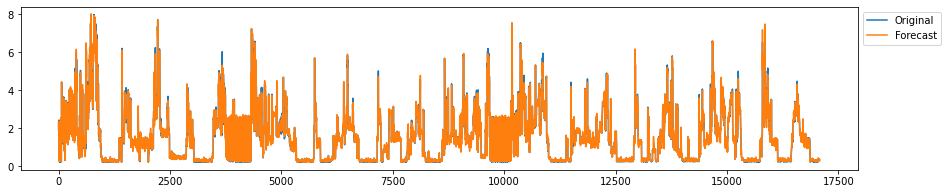

--------------------
training window 68309


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:34:47] getting statistics
Results: (0.0976285066994866, 0.03822499146025979, 2.3192149270838325, 1.107940533780793)


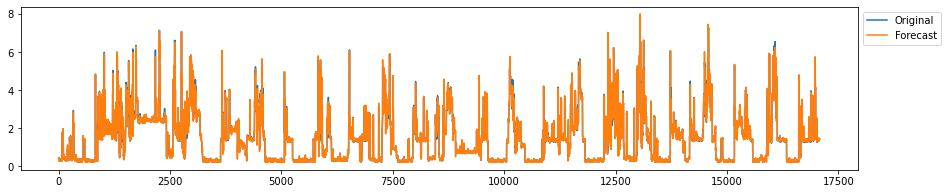

--------------------
training window 136618


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:36:08] getting statistics
Results: (0.11712518177198167, 0.06875876323549088, 18.099881807553942, 7.288833863997221)


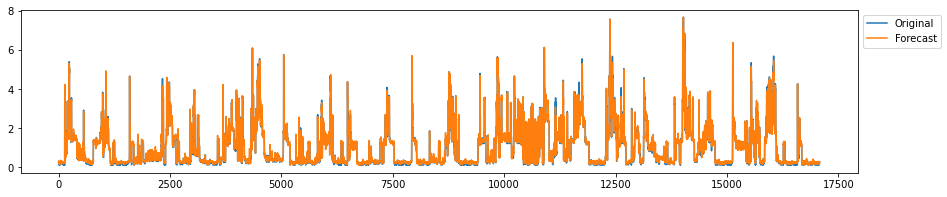

--------------------
training window 204927


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:37:19] getting statistics
Results: (0.17021542200006654, 0.07883443369955677, 22.56002924476816, 8.663880971113766)


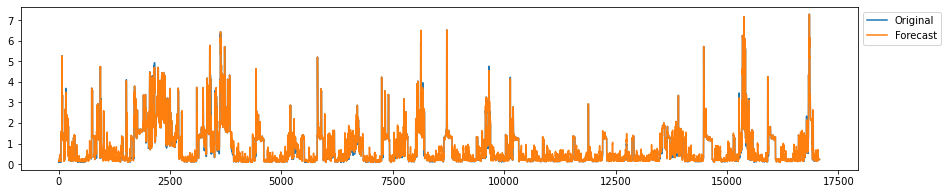

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 273236
[ 15:38:25] getting statistics
Results: (0.1734730545683886, 0.059578570439368386, 4.76070431166634, 3.0298457304069055)


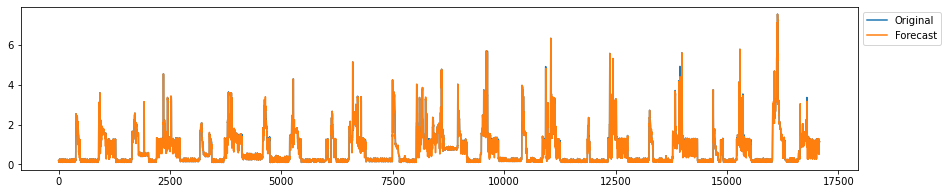

--------------------
training window 341545


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:39:34] getting statistics
Results: (0.11109422640267425, 0.04170250538387788, 3.8673280017688585, 1.9422027392175905)


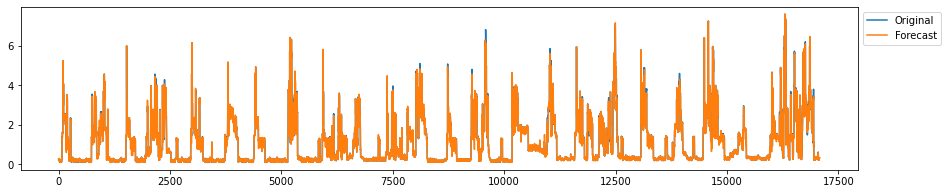

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 409854
[ 15:40:42] getting statistics
Results: (0.11542142551061114, 0.038171041902014195, 2.5016210240196495, 1.4413843117585179)


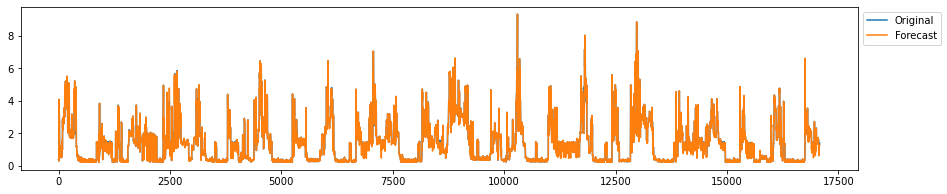

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 478163
[ 15:41:55] getting statistics
Results: (0.14346746064348387, 0.06414592198682449, 3.9132581555326467, 2.1511701431827053)


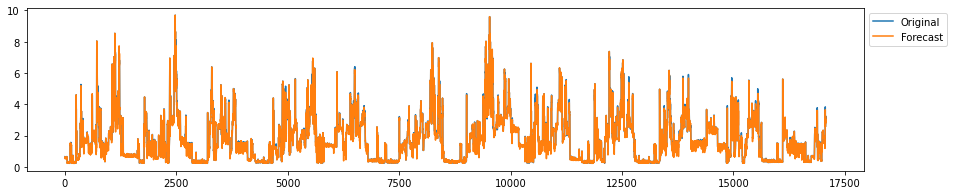

--------------------
training window 546472


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:43:07] getting statistics
Results: (0.07260864393239257, 0.04045351329734826, 6.974039180579977, 3.190474510687734)


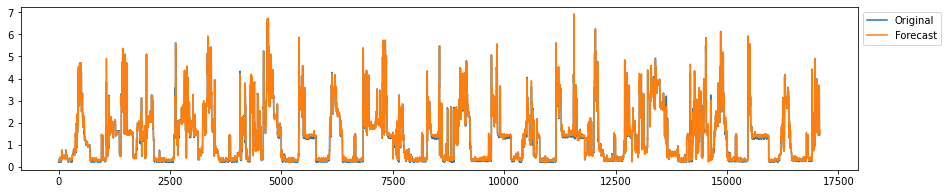

--------------------
training window 614781


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:44:18] getting statistics
Results: (0.09986775303224978, 0.04414067935557493, 7.44319818835862, 3.422074090111101)


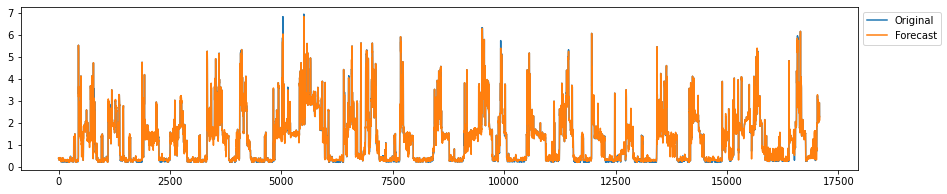

--------------------
training window 683090


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:45:36] getting statistics
Results: (0.08293316852699897, 0.052144756543655586, 13.139401899731123, 5.490947175608456)


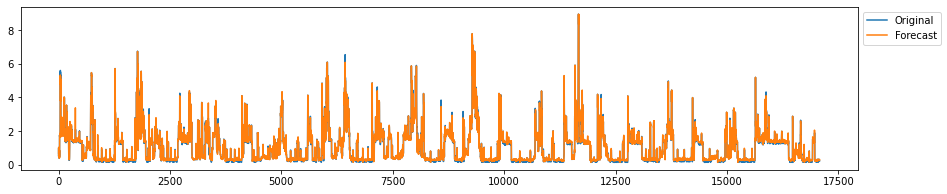

--------------------
training window 751399


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:46:55] getting statistics
Results: (0.16197412481296675, 0.13204591445071592, 35.96213597185102, 14.052304415630164)


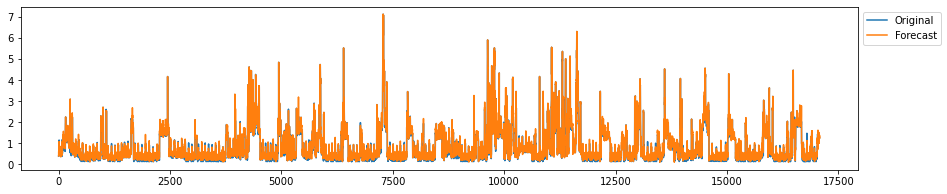

--------------------
training window 819708


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:48:06] getting statistics
Results: (0.024661941103694174, 0.013914008289209702, 8.758796874071635, 3.82171248651191)


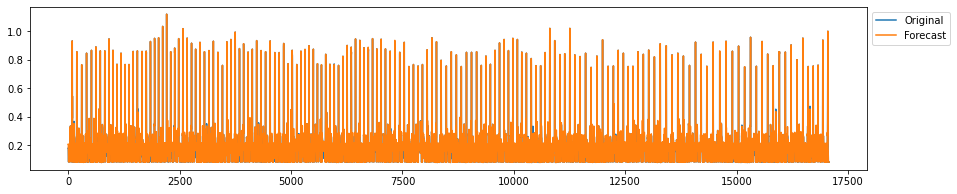

--------------------
training window 888017


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:49:22] getting statistics
Results: (0.07417593217651317, 0.04121289995268224, 4.737998021729708, 2.4448827273882117)


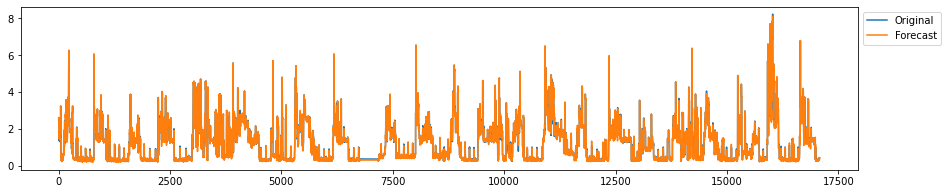

--------------------
training window 956326


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:50:28] getting statistics
Results: (0.11117355009830339, 0.03237010300850307, 1.5928068678197267, 0.753805448593625)


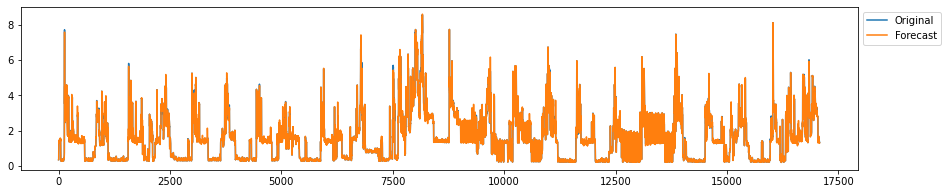

--------------------
training window 1024635


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:51:41] getting statistics
Results: (0.056045008440482845, 0.024854151128220436, 1.7798773819209797, 0.8770157569814295)


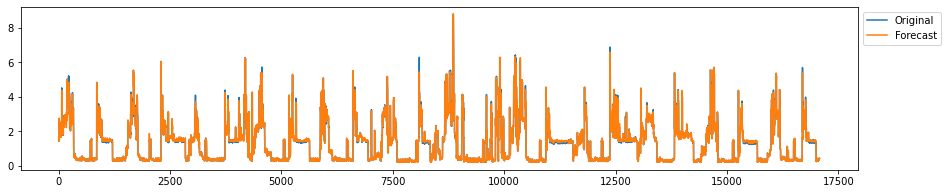

--------------------
training window 1092944


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:52:53] getting statistics
Results: (0.24992139255038523, 0.15713957295661435, 31.76748188704193, 11.048054500336518)


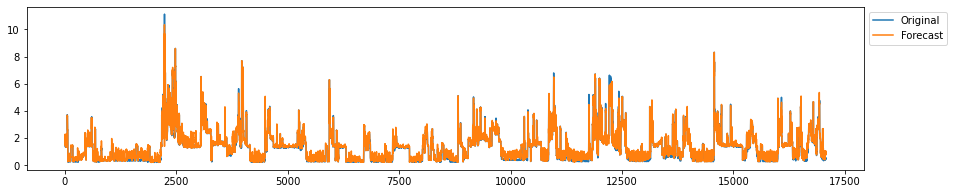

--------------------
training window 1161253


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:54:09] getting statistics
Results: (0.10236743063479381, 0.05172516245416731, 6.0127184051581715, 2.8859353919556257)


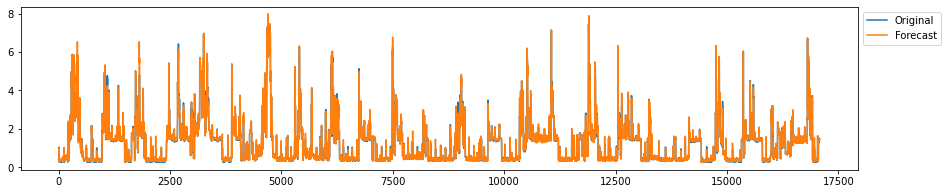

--------------------
training window 1229562


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:55:24] getting statistics
Results: (0.07679509292602849, 0.05248588636868963, 13.381943315404188, 5.711478323440444)


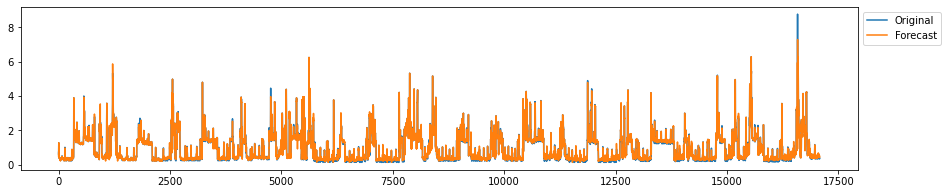

--------------------
training window 1297871


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:56:35] getting statistics
Results: (0.023629279712592165, 0.006689529997384649, 2.1205377861105132, 1.0299741859729956)


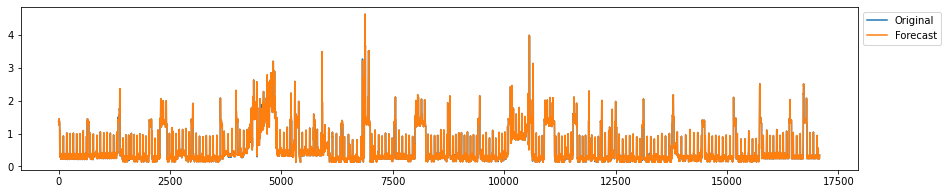

--------------------
training window 1366180


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:57:46] getting statistics
Results: (0.10220755760098127, 0.04970536397171111, 4.961108915485874, 2.432595341252463)


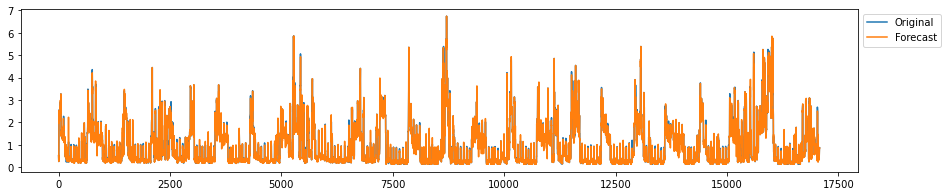

--------------------
training window 1434489


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:59:03] getting statistics
Results: (0.09587578523922828, 0.051348326297503355, 6.43447042097573, 3.0977795278760745)


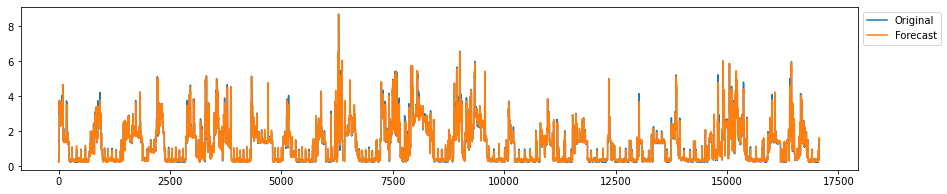

--------------------
training window 1502798


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 16:00:24] getting statistics
Results: (0.09630459962651199, 0.05204799705530276, 6.319433884714257, 3.030806964409435)


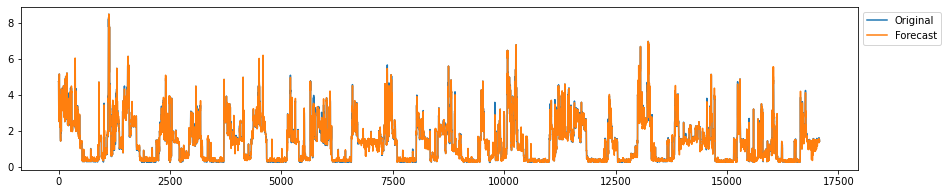

--------------------
training window 1571107


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 16:01:34] getting statistics
Results: (0.194878058021895, 0.09626444019291419, 5.979508033877349, 3.4470374406126965)


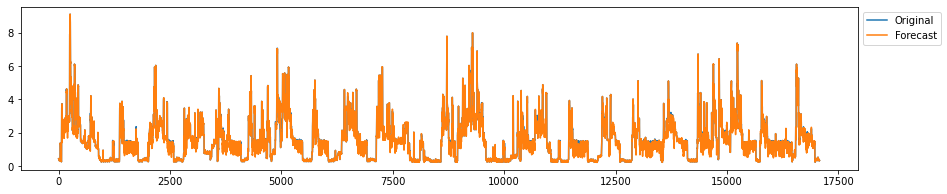

--------------------
training window 1639416


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 16:02:55] getting statistics
Results: (0.07849657433995044, 0.0483990760929002, 6.280556573957302, 3.02189507725983)


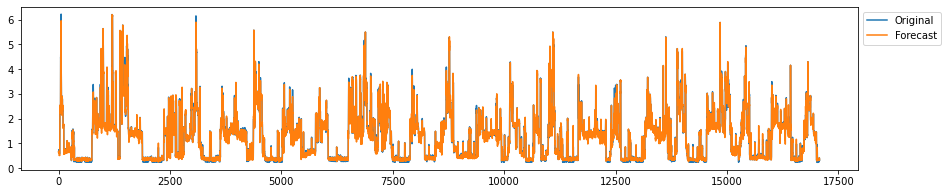

--------------------
training window 1707725


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 16:04:13] getting statistics
Results: (0.07742083345702278, 0.04453104218912566, 7.227544902449022, 3.383669323782619)


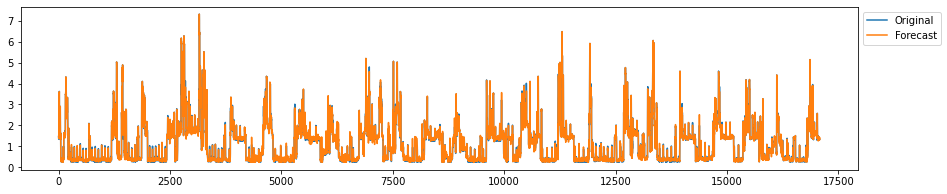

--------------------
training window 1776034


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 16:05:31] getting statistics
Results: (0.1233378626904449, 0.08931507245704433, 22.38130000234469, 8.839465666279244)


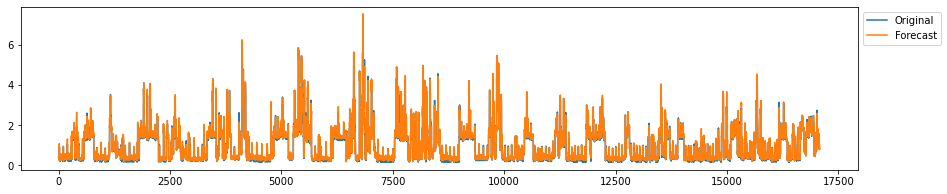

--------------------
training window 1844343


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 16:06:42] getting statistics
Results: (0.015183186980631494, 0.0040902468329531965, 1.4929322069487905, 0.7232313715492463)


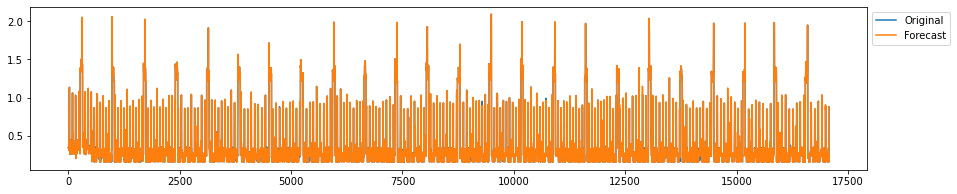

--------------------
training window 1912652


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 16:08:01] getting statistics
Results: (0.09426961759689524, 0.04331866681980191, 5.300439960693129, 2.536932253113456)


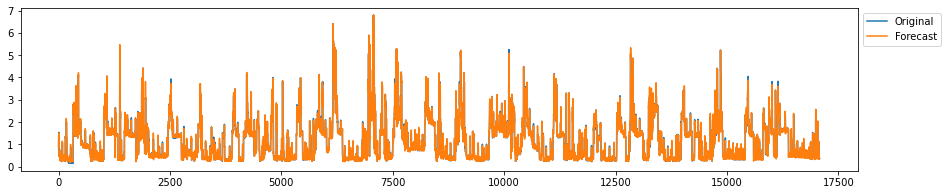

--------------------
training window 1980961


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 16:09:11] getting statistics
Results: (0.03668810034645565, 0.011970962884531365, 0.761620965996751, 0.37866487349554095)


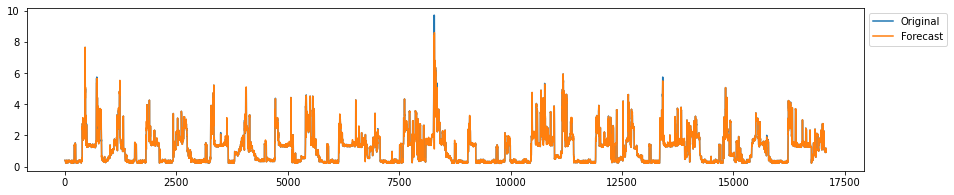

In [9]:
result = {
     "window": [],
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        
        data_train = ttrain.loc[:,'Global_active_power(t-1)':'Sub_metering_3(t-1)']
        data_test = ttest.loc[:,'Global_reactive_power(t-1)':'Global_active_power(t)']
         
        #ALtera o nome da columa porque o modelo utiliza esse label como variável endogena 
        data_test.rename(columns = {'Global_active_power(t)': 'Global_active_power(t-1)'}, inplace = True)
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model, pca_reduced_train = pca_wmvfts.run_train_model(data_train)
        forecast, forecast_self, pca_reduced_test = pca_wmvfts.run_test_model(model,data_test)
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        
        #Teste e cálculo dos erros da previsão  
        #valor use Global_reactive_power(t-1) é o Global_reactive_power(t) --> label igual por causa do modelo 
        rmse = Measures.rmse(pca_reduced_test['Global_active_power(t-1)'],forecast)
        mape = Measures.mape(pca_reduced_test['Global_active_power(t-1)'],forecast)
        smape = Measures.smape(pca_reduced_test['Global_active_power(t-1)'],forecast)
        
        forecast = pd.DataFrame(forecast)
        forecast.fillna(forecast.mean(),inplace=True)
        forecast = np.array(forecast).reshape(-1)
        mae = mean_absolute_error(pca_reduced_test['Global_active_power(t-1)'], forecast)
        
        print(f'Results: {(rmse,mae,mape,smape)}')
        
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(pca_reduced_test['Global_active_power(t-1)'], label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()
        
        result["rmse"].append(round(rmse,3))
        result["mape"].append(round(mape,3))
        result["smape"].append(round(smape,3))
        result["mae"].append(round(mae,3))
        result["window"].append(ct)
        
measures = pd.DataFrame(result)



In [12]:
measures

,window,rmse,mae,mape,smape
0,0,0.122,0.064,5.618,2.728
1,68309,0.098,0.038,2.319,1.108
2,136618,0.117,0.069,18.100,7.289
3,204927,0.170,0.079,22.560,8.664
4,273236,0.173,0.060,4.761,3.030
5,341545,0.111,0.042,3.867,1.942
6,409854,0.115,0.038,2.502,1.441
7,478163,0.143,0.064,3.913,2.151
8,546472,0.073,0.040,6.974,3.190
9,614781,0.100,0.044,7.443,3.422


### Mean Statistics PCA-WMVFTS:

In [13]:
final_result = {
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

final_result["rmse"].append(round(statistics.mean(measures['rmse']),3))
final_result["mae"].append(round(statistics.mean(measures['mae']),3))
final_result["mape"].append(round(statistics.mean(measures['mape']),3))
final_result["smape"].append(round(statistics.mean(measures['smape']),3))

        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics PCA-WMVFTS (test): ")
final_measures_pca

Mean Statistics PCA-WMVFTS (test): 


,rmse,mae,mape,smape
0,0.103,0.053,8.815,3.799


### Extras 

In [12]:
# pca_reduced_test

In [13]:
# print(model)

In [14]:
# train = sample_first_prows(data,0.75)
# test = data.iloc[max(train.index):]
# y_test = data.iloc[max(train.index):]['Appliances_t+1'].values

In [15]:
# pca_wmvfts = PcaWeightedMVFTS(n_components = 2,
#                        endogen_variable = 'Appliances_t+1',
#                        n_part = 50)

In [16]:
# model, pca_reduced_train = pca_wmvfts.run_train_model(train)
# forecast, forecast_self, pca_reduced_test = pca_wmvfts.run_test_model(model,test)

In [17]:
#model.mvflrg

In [18]:
# forecast_1 = model.predict(pca_reduced_test)

In [19]:
# Measures.rmse(y_test,forecast)

In [20]:
# Measures.rmse(forecast_1,y_test)

In [21]:
# Measures.rmse(y_test,forecast_self)

In [22]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
# ax.plot(y_test, label='Original')
# ax.plot(forecast, label='Forecast')
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
# plt.show()


In [23]:
# diff = data.loc[:,'lights':'Tdewpoint']
# diff = diff.diff()
# diff['Appliances'] = data['Appliances']
# data = diff.dropna()